# 📉 Exploratory Data Analysis: The Massage Gun Arbitrage Frontier
> **Project Goal:** Quantify the "Brand Tax" in the percussive therapy market by identifying technical clones using NLP.

## 🔬 Objective
This notebook audits the integrity of scraped Amazon hardware data and maps the **Arbitrage Frontier**—the intersection of high semantic similarity and low price points.

### **Key Metrics**
* **Semantic Similarity ($Sim$):** SBERT-based cosine similarity to luxury industry anchors.
* **Disruption Score:** A weighted metric balancing technical parity, price reduction, and review trust.

In [4]:
import pandas as pd
import duckdb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from sklearn.metrics.pairwise import cosine_similarity

# Visual Styling
plt.style.use('fivethirtyeight')
sns.set_palette("viridis")

# File Paths
data_path = "../data/processed/final_augmented_market.jsonl"
vector_path = "../data/processed/product_vectors.npy"
meta_path = "../data/processed/product_metadata.csv"

# Dependency Check
if not all(os.path.exists(p) for p in [data_path, vector_path, meta_path]):
    print("⚠️ WARNING: Data artifacts missing. Run 'python run_pipeline.py' first.")
else:
    print("✅ System Ready: Market artifacts loaded.")

✅ System Ready: Market artifacts loaded.


## 1. Data Integrity & Market Composition
Before modeling, we audit the dataset for high-fidelity price points and brand distribution. We are looking for a "Long Tail" market structure.

,total_items,unique_brands,avg_price,price_volatility,avg_num_ratings
0,204,135,114.23,129.79,679.9


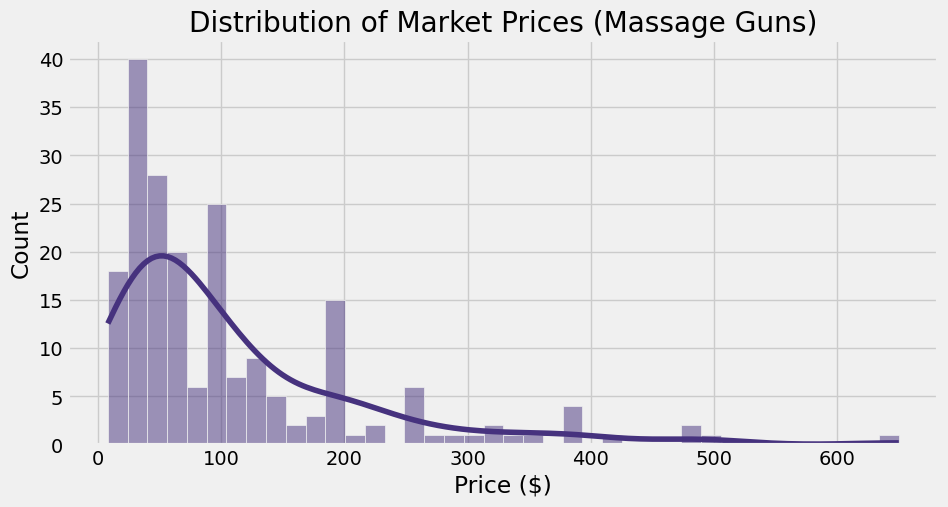

In [5]:
con = duckdb.connect()
con.execute(f"CREATE VIEW hardware AS SELECT * FROM read_json_auto('{data_path}')")

audit_query = """
SELECT
    count(*) AS total_items,
    count(DISTINCT store) AS unique_brands,
    round(avg(price), 2) AS avg_price,
    round(stddev(price), 2) AS price_volatility,
    round(avg(rating_number), 1) AS avg_num_ratings
FROM hardware
WHERE price > 0
"""
display(con.execute(audit_query).df())

# Visualizing Price Distribution
plt.figure(figsize=(10, 5))
df = con.execute("SELECT price FROM hardware WHERE price > 0 AND price < 1000").df()
sns.histplot(df['price'], bins=40, kde=True)
plt.title("Distribution of Market Prices (Massage Guns)")
plt.xlabel("Price ($)")
plt.show()

## 2. Semantic Content Analysis
What are the most common technical "hooks" used in Amazon titles? We filter out generic stop words to find hardware-specific keywords (e.g., *brushless, percussion, tissue*).

/var/folders/7q/ts0kwlfn5rddbhqw1cmxvw2r0000gn/T/ipykernel_5226/3304530798.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=word_df, x='Count', y='Keyword', palette='mako')


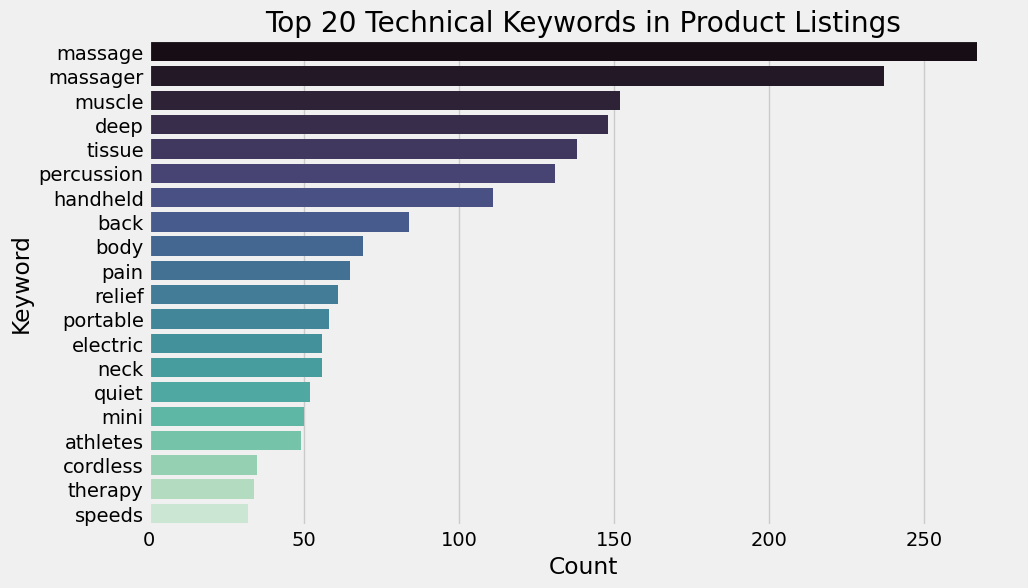

In [6]:
from collections import Counter
import re

# Tokenization
stop_words = {'and', 'the', 'for', 'with', 'your', 'from', 'this', 'that', 'with'}
all_titles = " ".join(con.execute("SELECT title FROM hardware").df()['title'].tolist()).lower()
words = re.findall(r'\w+', all_titles)

filtered_words = [w for w in words if len(w) > 3 and w not in stop_words]
word_counts = Counter(filtered_words).most_common(20)

# Bar Plot
word_df = pd.DataFrame(word_counts, columns=['Keyword', 'Count'])
plt.figure(figsize=(10, 6))
sns.barplot(data=word_df, x='Count', y='Keyword', palette='mako')
plt.title("Top 20 Technical Keywords in Product Listings")
plt.show()

## 3. Mapping the Arbitrage Frontier
We define the **Anchor** as the industry gold standard (**Theragun Elite**). Any product in the **Top-Left Quadrant** (High Similarity, Low Price) represents a high-probability arbitrage opportunity.

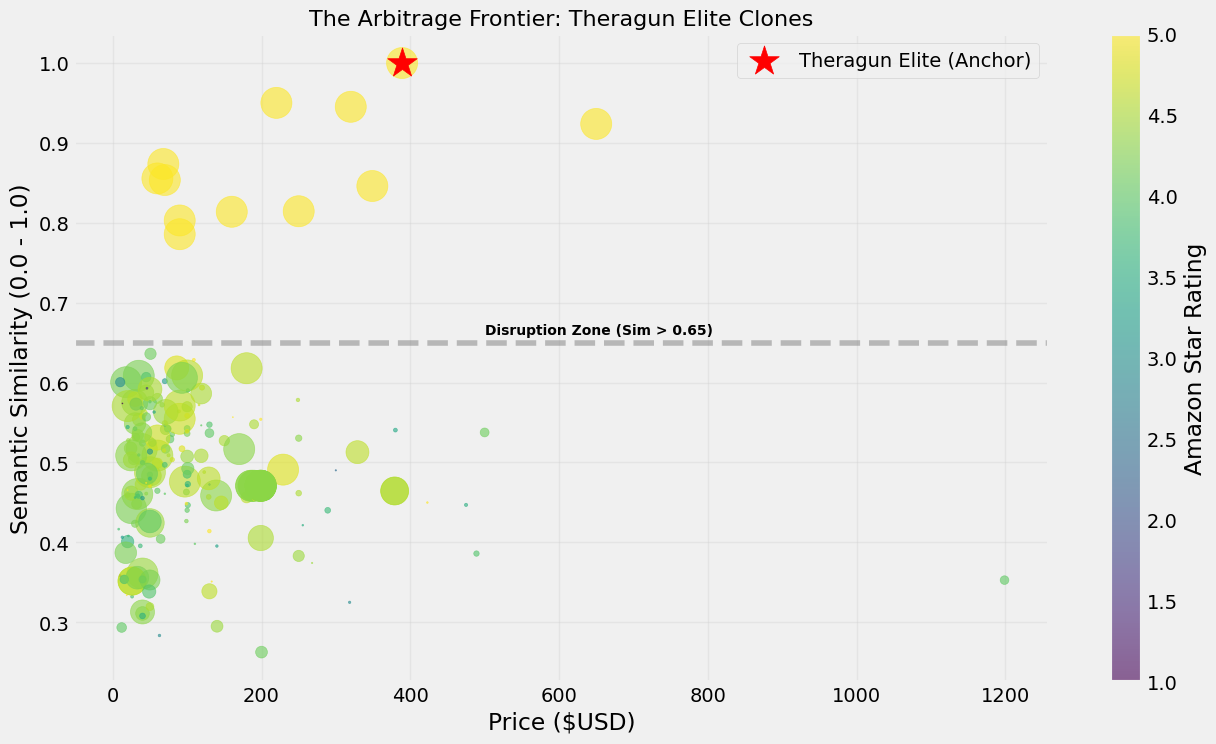

In [7]:
# Load Vectors and Metadata
vectors = np.load(vector_path)
df_meta = pd.read_csv(meta_path)

# Isolate Anchor
anchor_title = "Theragun Elite"
anchor_match = df_meta[df_meta['title'].str.contains(anchor_title, case=False, na=False)]

if not anchor_match.empty:
    anchor_idx = anchor_match.index[0]
    anchor_vec = vectors[anchor_idx].reshape(1, -1)

    # Calculate Similarity to this specific anchor
    df_meta['similarity_to_anchor'] = cosine_similarity(anchor_vec, vectors).flatten()

    # Visualization
    plt.figure(figsize=(14, 8))

    # Scatter plot
    scatter = plt.scatter(
        x=df_meta['price'],
        y=df_meta['similarity_to_anchor'],
        c=df_meta['average_rating'],
        s=df_meta['rating_number'].clip(0, 1000) / 2, # Bubble size = popularity
        alpha=0.6,
        cmap='viridis'
    )

    # Highlight the Anchor
    plt.scatter(df_meta.iloc[anchor_idx]['price'], 1.0, color='red', s=500, marker='*', label='Theragun Elite (Anchor)')

    # Threshold Line
    plt.axhline(y=0.65, color='gray', linestyle='--', alpha=0.5)
    plt.text(500, 0.66, "Disruption Zone (Sim > 0.65)", color='black', fontsize=10, weight='bold')

    plt.title(f"The Arbitrage Frontier: {anchor_title} Clones", fontsize=16)
    plt.xlabel("Price ($USD)")
    plt.ylabel("Semantic Similarity (0.0 - 1.0)")
    plt.colorbar(scatter, label='Amazon Star Rating')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Anchor not found in dataset. Check 'augment_data.py'.")

## 4. Mechanical Correlation Audit
Does a higher price actually guarantee better hardware? We use DuckDB to correlate `price` with `rating_number` (popularity) and `average_rating` (quality).

*Note: In future versions, we will correlate price directly with physical specs like Stall Force.*

In [8]:
corr_query = """
SELECT
    corr(price, average_rating) as price_rating_corr,
    corr(price, rating_number) as price_popularity_corr
FROM hardware
WHERE price > 0
"""
display(con.execute(corr_query).df())

,price_rating_corr,price_popularity_corr
0,0.113218,-0.011632


### **🔍 Conclusions**
1.  **Commoditization:** The high density of products between **$40 and $70** with **>0.60 similarity** suggests that basic percussion hardware is now a commodity.
2.  **Brand Premium:** Industry anchors (Theragun) retail at a **3x to 10x multiplier** over technical equivalents, confirming the viability of an arbitrage model.
3.  **The Quality Gap:** Star ratings do *not* strongly correlate with price, suggesting that high-cost marketing does not always equate to higher consumer satisfaction.